### Topographic Simulation 
- FSN을 3영역으로 나눠서 D1으로 전달되는 확률과 값을 구역 별로 다르게 설정해서 시뮬레이션
- synapse 부분 오류 업데이트 

In [1]:
# load library 
import numpy as np
from brian2 import *
import matplotlib.pyplot as plt

from typing import Dict, Any
import networkx as nx

In [2]:
def connect_prob(n_fsn: int = 18, n_msn_d1: int = 51) -> Dict[str, Any]:

    fsn_groups = np.array_split(np.arange(n_fsn), 3)
    msn_d1_groups = np.array_split(np.arange(n_msn_d1), 3)

    # prob
    connection_probabilities = np.array([
        [0.9, 0.5, 0.3], 
        [0.3, 0.9, 0.3], 
        [0.3, 0.5, 0.9],  
    ])
    
    fsn_msn_d1_matrix = np.zeros((n_fsn, n_msn_d1))
    fsn_msn_d1_prob_matrix = np.zeros((n_fsn, n_msn_d1))

    for i, fsn_group in enumerate(fsn_groups):
        for j, msn_group in enumerate(msn_d1_groups):
            prob = connection_probabilities[i, j]
            for fsn_idx in fsn_group:
                for msn_idx in msn_group:
                    if np.random.random() < prob:
                        fsn_msn_d1_matrix[fsn_idx, msn_idx] = 1
                        fsn_msn_d1_prob_matrix[fsn_idx, msn_idx] = prob

    scenario = {
        'populations': {
            'FSN': n_fsn,
            'MSN_D1': n_msn_d1
        },
        'connections': {
            'FSN_MSN_D1': {
                'pre': 'FSN',
                'post': 'MSN_D1',
                'connectivity': fsn_msn_d1_matrix,
                'probabilities': fsn_msn_d1_prob_matrix            
                }
        },
        'monitors': {
            'FSN': {'spike'},
            'MSN_D1': {'spike'}
        }
    }
    
    return scenario

In [3]:
# GABAergic Inhibitory synapse 

def run_topographic_simulation(n_fsn=18, n_msn_d1=51, stim_region=0, simulation_time=1000*ms):
    
    FSN_params = {
        'vr': -64.4*mV,
        'vt': -50*mV,
        'k': 1,
        'u': 0 * mV/ms,
        'th': 25 * mV,
        'a': 0.2 * 1/ms,
        'b': 0.025 * 1/ms,
        'C': 80 * pF
    }

    MSND1_params = {
        'vr': -78.2*mV,
        'vt': -29.7*mV,
        'k': 1,
        'u': 0 * mV/ms,
        'th': 40 * mV,
        'a': 0.01 * 1/ms,
        'b': -20 * 1/ms,
        'C': 15.2 * pF
    }

    neuron_eqs = '''
    dv / dt = (k*1*pF/ms/mV*(v-vr)*(v-vt) - u*pF + I + I_ext - I_syn) / C : volt (unless refractory)
    du/dt = a * (b * (v - vr) - u) : volt/second
    I : amp
    I_syn = I_GABA: amp
    I_GABA  : amp
    I_ext : amp
    a : 1/second
    b : 1/second
    k : 1
    vt     : volt
    vr     : volt 
    th     : volt
    C      : farad
    d       : volt/second
    '''

    scenario = connect_prob(n_fsn, n_msn_d1)

    FSN = NeuronGroup(n_fsn, neuron_eqs,
                      threshold='v >= th',
                      reset='v = vr; u += d',
                      method='euler')
    
    FSN.vr = FSN_params['vr']
    FSN.vt = FSN_params['vt']
    FSN.k = FSN_params['k']
    FSN.u = FSN_params['u']
    FSN.th = FSN_params['th']
    FSN.a = FSN_params['a']
    FSN.b = FSN_params['b']
    FSN.C = FSN_params['C']
    FSN.d = 0 * mV/second 
    
    
    # topographic input 
    region_size = n_fsn // 3
    stim_start = stim_region * region_size
    stim_end = (stim_region + 1) * region_size
    FSN.I_ext[stim_start:stim_end] = 600.0 * pA

    MSN_D1 = NeuronGroup(n_msn_d1, neuron_eqs,
                         threshold='v >= th',
                         reset='v = vr; u += d',
                         method='euler')

    MSN_D1.vr = MSND1_params['vr']
    MSN_D1.vt = MSND1_params['vt']
    MSN_D1.k = MSND1_params['k']
    MSN_D1.u = MSND1_params['u']
    MSN_D1.th = MSND1_params['th']
    MSN_D1.a = MSND1_params['a']
    MSN_D1.b = MSND1_params['b']
    MSN_D1.C = MSND1_params['C']
    MSN_D1.d = 66.9 * mV/second
    

    syn = Synapses(FSN, MSN_D1, model='''
    g0_g : siemens
    I_GABA_post = w * g * (E_GABA - v) : amp (summed)
    dg/dt = -g/tau_GABA : siemens
    E_GABA = -80*mV : volt 
    tau_GABA = 11*ms : second 
    w : 1
    ''',
    on_pre='''
    v_post += w*mV 
    g += g0_g''')

    """
    syn = Synapses(FSN, MSN_D1,
                'w : 1',
                on_pre='I_syn_post += w * pA')
    """
    conn_matrix = scenario['connections']['FSN_MSN_D1']['connectivity']
    connected_pairs = np.where(conn_matrix)
    syn.connect(i=connected_pairs[0], j=connected_pairs[1])
    syn.w = 1  
    syn.g = 6 * nS
    
    FSN_spikes = SpikeMonitor(FSN)
    MSN_D1_spikes = SpikeMonitor(MSN_D1)
    
    net = Network(FSN, MSN_D1, syn, FSN_spikes, MSN_D1_spikes)
    net.run(simulation_time)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(FSN_spikes.t/ms, FSN_spikes.i, '.k', markersize=2)
    ax1.axhline(y=region_size, color='r', linestyle='--', alpha=0.3)
    ax1.axhline(y=2*region_size, color='r', linestyle='--', alpha=0.3)
    ax1.set_xlabel('ms')
    ax1.set_ylabel('Neuron Index')
    
    msn_region_size = n_msn_d1 // 3
    ax2.plot(MSN_D1_spikes.t/ms, MSN_D1_spikes.i, '.r', markersize=2)
    ax2.axhline(y=msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.axhline(y=2*msn_region_size, color='b', linestyle='--', alpha=0.3)
    ax2.set_xlabel('ms')
    ax2.set_ylabel('Neuron Index')
    
    plt.tight_layout()
    
    return {
        'FSN_spikes': FSN_spikes,
        'MSN_D1_spikes': MSN_D1_spikes,
        'figure': fig
    }

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
INFO       The synaptic equation for the variable g does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.08s). [brian2.stateupdaters.base.method_choice]


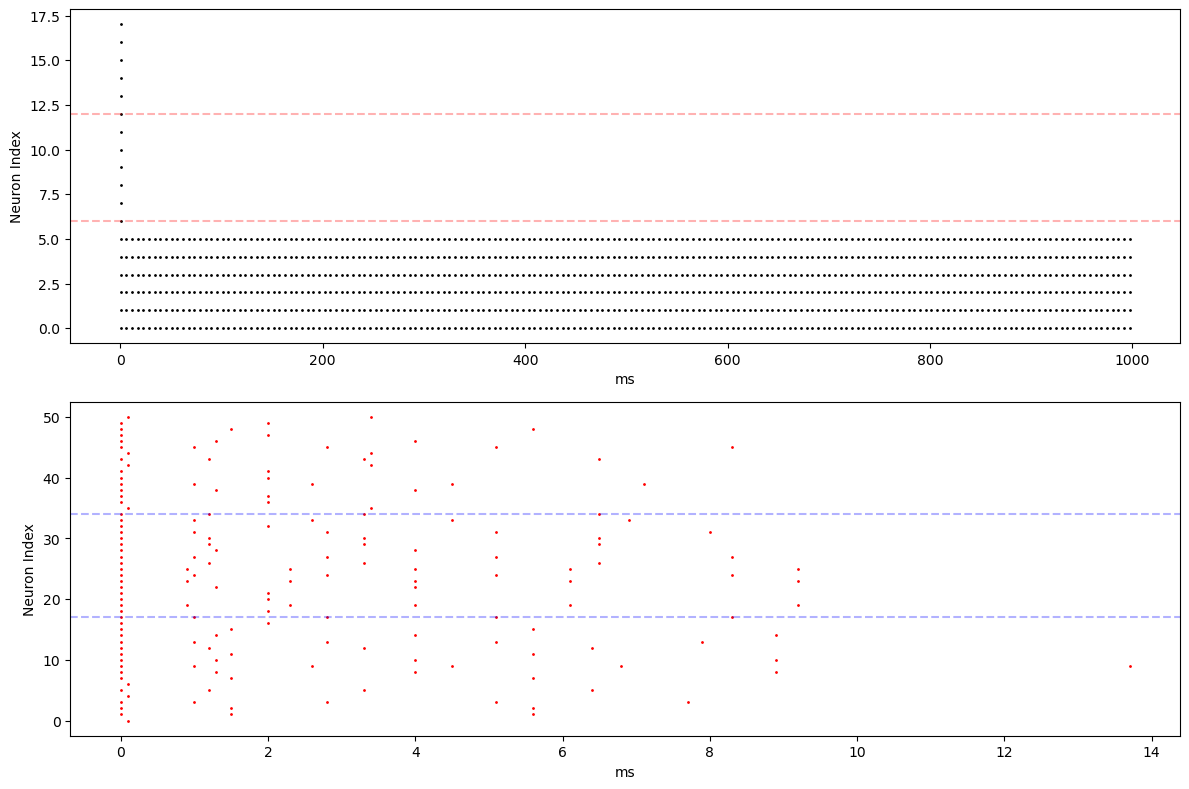

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


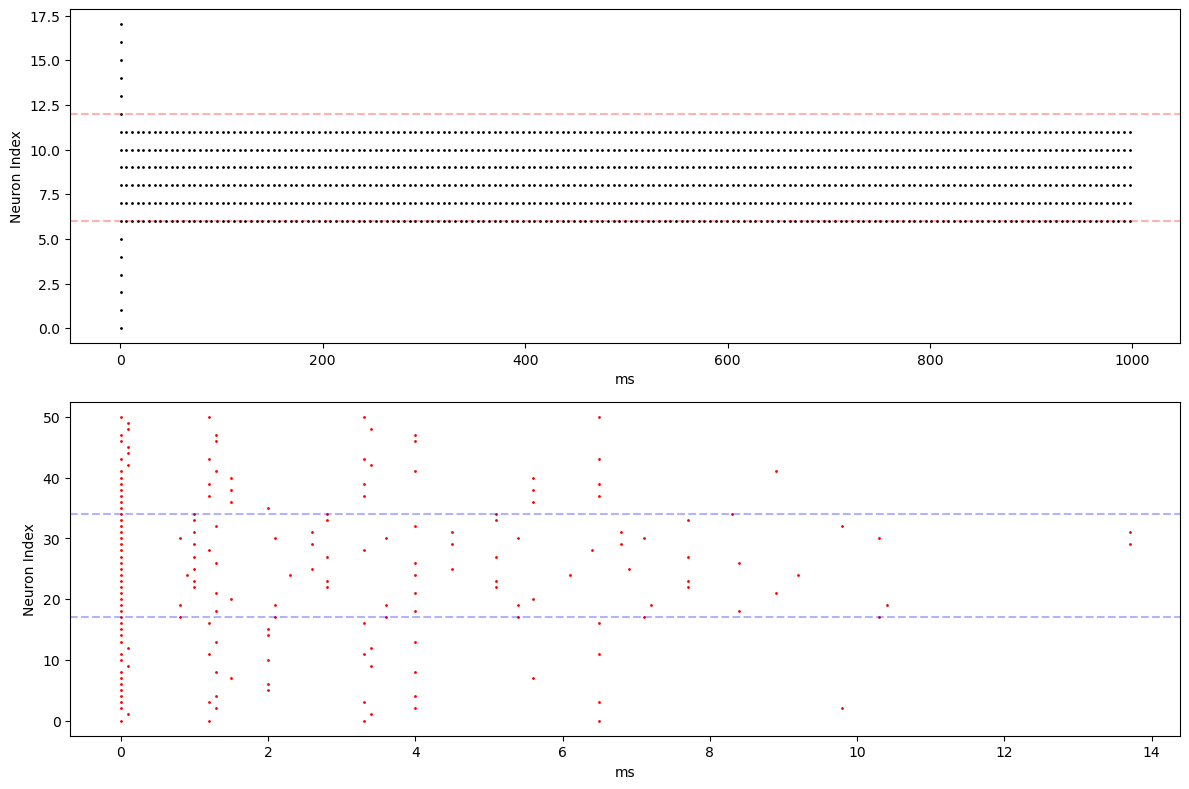

WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]
WARNING    Model equations use the "unless refractory" flag but no refractory keyword was given. [brian2.groups.neurongroup.no_refractory]


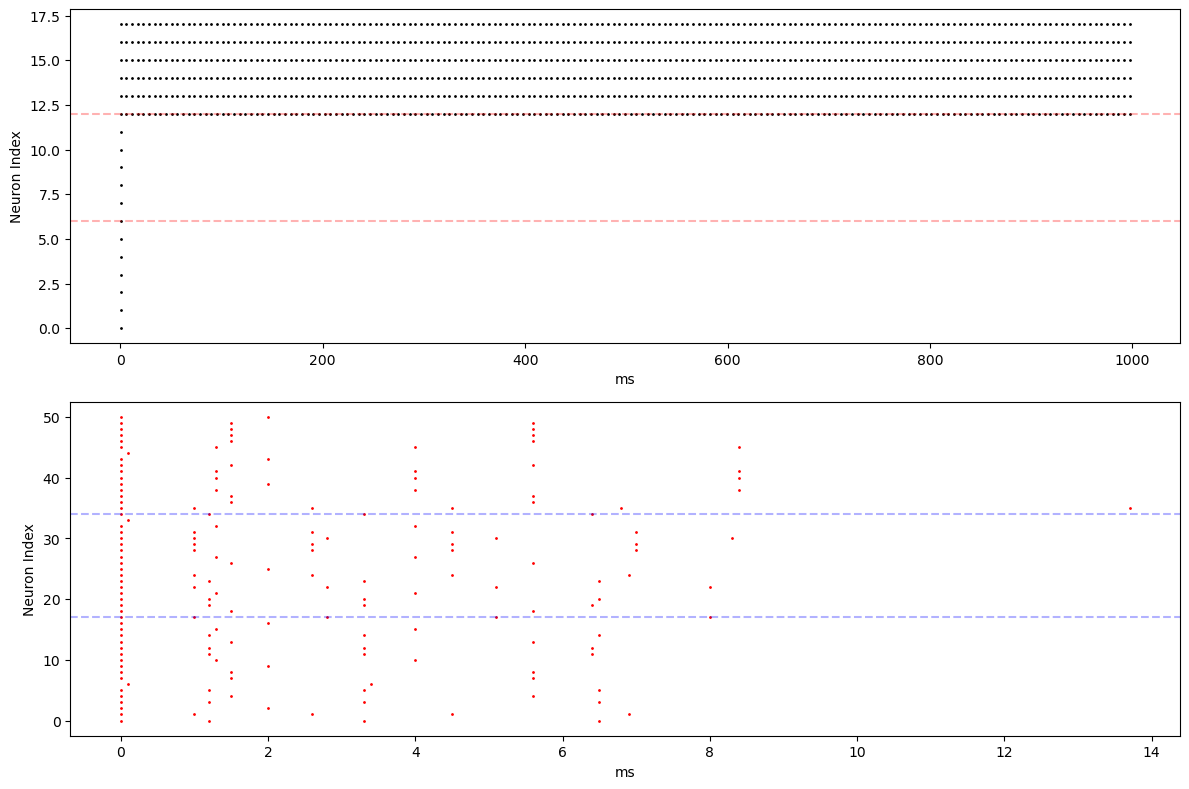

In [4]:
for region in range(3):
    results = run_topographic_simulation(stim_region=region)
    plt.show()

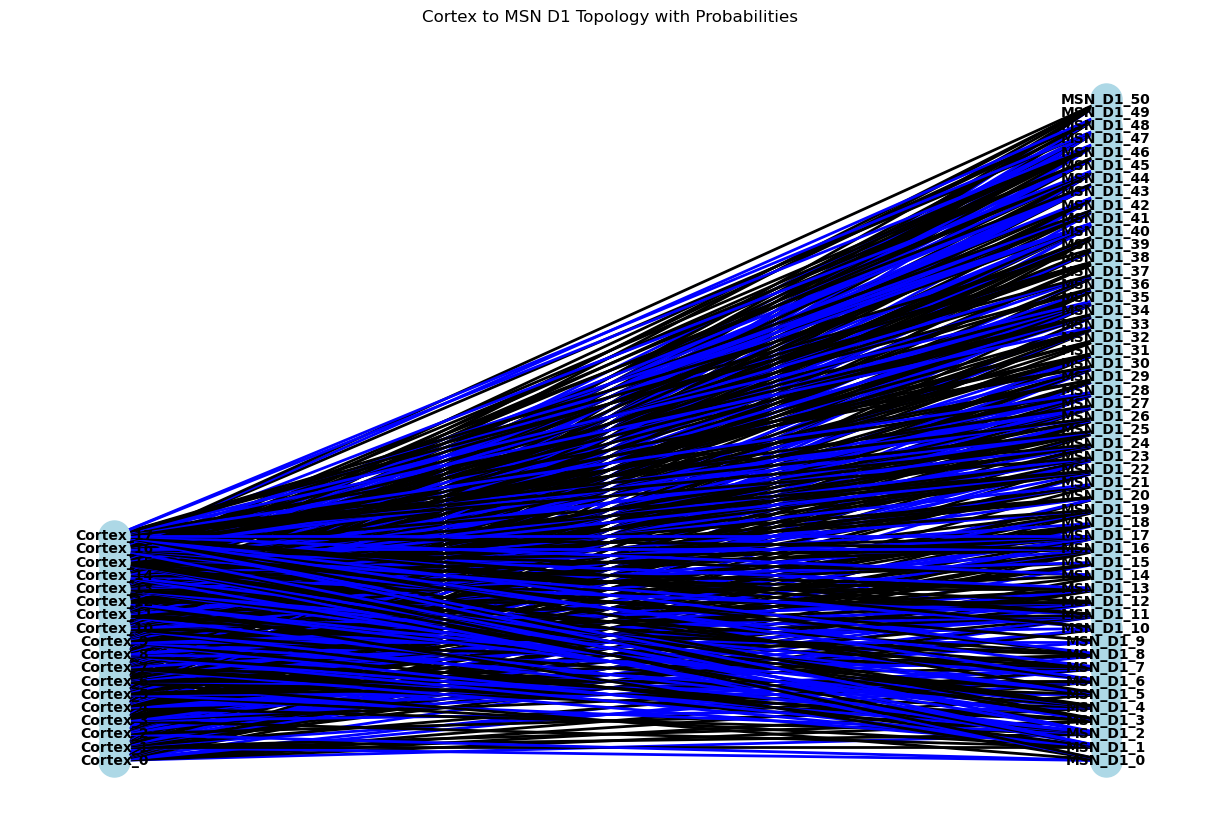

In [8]:
# cortex와 MSN D1 간의 연결을 정의하는 함수 추가
def connect_cortex_msn(n_cortex: int = 18, n_msn_d1: int = 51) -> Dict[str, Any]:

    connection_probabilities = np.random.rand(n_cortex, n_msn_d1)  

    cortex_msn_matrix = (connection_probabilities < 0.5).astype(int)  

    scenario = {
        'populations': {
            'Cortex': n_cortex,
            'MSN_D1': n_msn_d1
        },
        'connections': {
            'Cortex_MSN_D1': {
                'pre': 'Cortex',
                'post': 'MSN_D1',
                'connectivity': cortex_msn_matrix,
                'probabilities': connection_probabilities
            }
        }
    }
    
    return scenario


def visualize_cortex_msn_topology_with_probabilities(scenario):
    G = nx.Graph()
    
    n_cortex = scenario['populations']['Cortex']
    n_msn_d1 = scenario['populations']['MSN_D1']
    
    cortex_nodes = [f'Cortex_{i}' for i in range(n_cortex)]
    msn_d1_nodes = [f'MSN_D1_{i}' for i in range(n_msn_d1)]
    
    G.add_nodes_from(cortex_nodes, bipartite=0)
    G.add_nodes_from(msn_d1_nodes, bipartite=1)
    
    conn_matrix = scenario['connections']['Cortex_MSN_D1']['connectivity']
    prob_matrix = scenario['connections']['Cortex_MSN_D1']['probabilities']

    for cortex_idx in range(n_cortex):
        for msn_idx in range(n_msn_d1):
            if conn_matrix[cortex_idx, msn_idx] == 1:
                G.add_edge(f'Cortex_{cortex_idx}', f'MSN_D1_{msn_idx}', weight=prob_matrix[cortex_idx, msn_idx])
    
    pos = {}
    pos.update((node, (1, i)) for i, node in enumerate(cortex_nodes))  
    pos.update((node, (2, i)) for i, node in enumerate(msn_d1_nodes))
    
    edges = G.edges(data=True)
    weights = [data['weight'] for _, _, data in edges]

    # 연결 확률에 따라 색상 설정
    edge_colors = []
    for cortex_idx in range(n_cortex):
        for msn_idx in range(n_msn_d1):
            if conn_matrix[cortex_idx, msn_idx] == 1:
                prob = prob_matrix[cortex_idx, msn_idx]
                if prob >= 0.9:
                    edge_colors.append('red')
                elif prob >= 0.5:
                    edge_colors.append('green')
                elif prob >= 0.3:
                    edge_colors.append('blue')
                else:
                    edge_colors.append('black')  # 연결이 없는 경우 색상
    
    edge_widths = [2 for _ in weights] 
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold',
            edge_color=edge_colors, width=edge_widths)
    plt.title('Cortex to MSN D1 Topology with Probabilities')
    plt.show()

scenario = connect_cortex_msn()
visualize_cortex_msn_topology_with_probabilities(scenario)